In [300]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from matplotlib.patches import Patch
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns

from lib.model import FNO1d
from lib.dataset import PDEDatasetAll2All
from lib.utils import relative_l2_error, calculate_errors

In [301]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [302]:
torch.manual_seed(0)
np.random.seed(0)

In [303]:
BATCH_SIZE = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model_finetune.pth", weights_only=True,  map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [305]:
dataset = PDEDatasetAll2All("data/OOD_fine_tune_allen_cahn.npz", device=DEVICE)

print("Dataset size: ", len(dataset))

Dataset size:  2250


In [306]:
tune_data, validation_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [307]:
tune_data_loader = DataLoader(tune_data, batch_size=BATCH_SIZE, shuffle=True)
validation_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)

In [308]:
learning_rate = 0.00005
epochs = 5
step_size = 20
gamma = 0.5

In [309]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = step_size, eta_min=1e-6)

In [310]:
def loss_f(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return relative_l2_error(output, target, dim=-1).sum()

In [311]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

In [312]:
best_val_loss = float("inf")
progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    fno.train()
    train_loss = 0.0
    for i, (dt, eps, input, target) in enumerate(tune_data_loader):
        optimizer.zero_grad()
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(tune_data)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())

    # Compute validation loss
    fno.eval()
    validation_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(validation_data_loader):
        with torch.no_grad():
            prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1).sum()
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(validation_data)
    metrics["validation_loss"].append(validation_relative_l2)

    scheduler.step()

    # Save best model
    if validation_relative_l2 < best_val_loss:
        best_val_loss = validation_relative_l2
        torch.save(fno.state_dict(), "models/tfno_model.pth")

    # Update progress bar
    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "best_val_loss": best_val_loss,
            "lr": scheduler.get_last_lr(),
        },
    )


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  1.74it/s, train_loss=0.0289, best_val_loss=0.0175, lr=[4.2824116139070415e-05]]


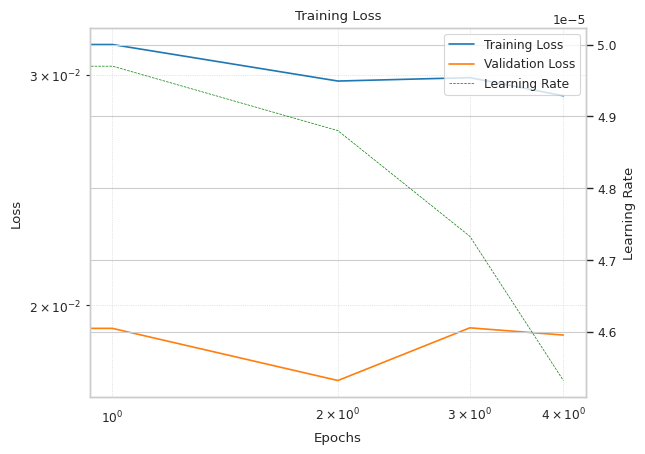

In [313]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [314]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset_ood = PDEDatasetAll2All(
    "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors_all, ood_relative_l2_all = calculate_errors(fno, dataset_ood)

print(rf"OOD relative L2 error: {ood_relative_l2_all:.4f}")

 94%|█████████▍| 30/32 [00:00<00:00, 55.87it/s]

100%|██████████| 32/32 [00:00<00:00, 56.74it/s]

OOD relative L2 error: 0.1794


In [315]:
time_pairs = [(0, 4)]
dataset_ood = PDEDatasetAll2All(
    "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors_t1, ood_relative_l2_t1 = calculate_errors(fno, dataset_ood)

print(rf"OOD relative L2 error (u_0 -> u(t=1.0)): {ood_relative_l2_t1:.4f}")

100%|██████████| 8/8 [00:00<00:00, 53.97it/s]

OOD relative L2 error (u_0 -> u(t=1.0)): 0.1567


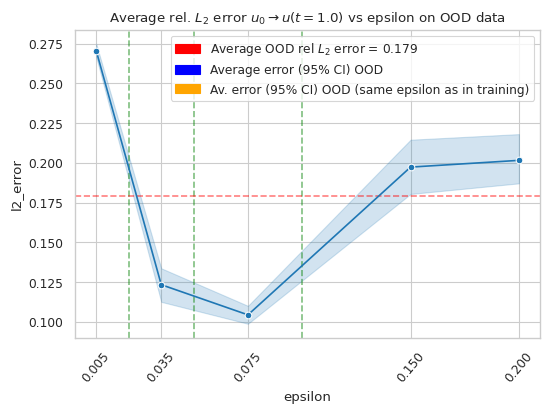

In [316]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(6, 4))
# add vertical lines at epsilons seen in the training data [0.1, 0.05, 0.02]
epsilons = [0.1, 0.05, 0.02]
for epsilon in epsilons:
    plt.axvline(x=epsilon, color="g", linestyle="--", alpha=0.5, label=f"epsilon = {epsilon} seen during training")
    
plt.axhline(y=ood_relative_l2_all, color="r", linestyle="--", alpha=0.5)

sns.lineplot(data=errors_all, x="epsilon", y="l2_error", ax=ax, marker="o")
# sns.lineplot(data=errors_same_eps, x="epsilon", y="l2_error", ax=ax, marker="o", color="orange")
# set ticks to epsilon
ax.set_xticks(errors_all["epsilon"].unique())

# set x ticks vertical
plt.xticks(rotation=50)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=rf"Average OOD rel $L_2$ error = {ood_relative_l2_all:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Average error (95% CI) OOD"),
        Patch(facecolor="orange", edgecolor="orange", label="Av. error (95% CI) OOD (same epsilon as in training)"),
        # Patch(facecolor="g", edgecolor="g", label="Epsilons seen during training"),
    ]
)
plt.title(r"Average rel. $L_2$ error $u_0 \rightarrow u(t=1.0)$ vs epsilon on OOD data")
plt.savefig("figures/ac_ood_l2_vs_eps.png", dpi=300, bbox_inches="tight")
plt.show()